# Machine Analysis

These notebooks look to analyse the time spent by each patient at the different machines. They use the geopandas package to capture the points in the polygons representing the different machines. They then look to capture the time spent in that machine.

## Package and Function Load In

In [ ]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [ ]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos

     |████████████████████████████████| 1.0 MB 29.6 MB/s 
     |████████████████████████████████| 16.7 MB 326 kB/s 
     |████████████████████████████████| 6.3 MB 59.1 MB/s 
     |████████████████████████████████| 1.0 MB 26.7 MB/s 
     |████████████████████████████████| 2.1 MB 25.8 MB/s 


## File Load In

In this section you must load in the appropriate patient journey file for analysis.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.geometry import box
from shapely import wkt
import pandas as pd
import rtree
import pygeos
import geopandas as gpd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

dftest = pd.read_csv('phase2_all_20220130.csv')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Creating the Machine Polygon or MultiPolygon

The polygon coordinates are captured using the line_with_coordinates.html file. The polygon coordinates must be entered in the order of top left, bottom left, bottom right and then top right.

In [ ]:
OCT_poly1 = Polygon([(12.7, 13.5), (12.7, 7.9), (14.9, 7.9), (14.9, 13.5)])

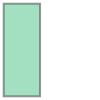

In [ ]:
OCT_poly1

In [ ]:
OCT_poly2 = Polygon([(16.2, 13.4), (16.2, 7.8), (18.4, 7.8), (18.4, 13.4)])

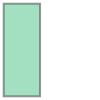

In [ ]:
OCT_poly2

In [ ]:
OCT_poly3 = Polygon([(17.9, 15.7), (17.9, 13.7), (20.0, 13.7), (20.0, 15.7)])

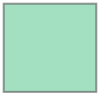

In [ ]:
OCT_poly3

## MultiPolygon Creation

In this example there are two separate sections for the machines. So multiple polygons must be created and subsequently combined to create a MultiPolygon.

In [ ]:
OCT_multipoly = MultiPolygon([OCT_poly1, OCT_poly2, OCT_poly3])

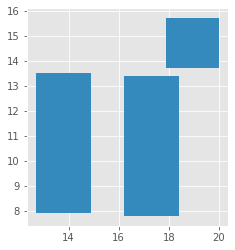

In [ ]:
 p = gpd.GeoSeries(OCT_multipoly)
 p.plot()
 plt.show()

## Data Cleaning and Formatting

In [ ]:
dftest = dftest.dropna()
dftest[['xlocation', 'ylocation']] = dftest['Location'].str.split(',', expand = True)

In [ ]:
dfG1221 = dftest.loc[dftest['Patient'] == 'G1221']

In [ ]:
column_list = list(dftest)
column_list

['Patient', 'Location', 'from', 'to', 'xlocation', 'ylocation']

## GeoPandas Dataframe Creation

This section creates a GeoPandas dataframe using the coordinates from the patient journey dataset.

The next section creates a geometry using the polygon or MultiPolygon shape that was created earlier.

In [ ]:
gdf = gpd.GeoDataFrame(
    dftest, geometry=gpd.points_from_xy(dftest.xlocation, dftest.ylocation))

In [ ]:
gdf['Location'] = gdf['Location'].astype(str)

In [ ]:
OCT_multipoly_gdf = gpd.GeoDataFrame(geometry  = gpd.GeoSeries(OCT_multipoly))

In [ ]:
OCT_multipoly_gdf

,geometry
0,"MULTIPOLYGON (((12.70000 13.50000, 12.70000 7...."


## Inner Join of the Two GeoPandas DataFrames

This section runs a spatial join of the two GeoDataframes it captures all of the points, in this example the patient journey points, that occur with in the polygon or MultiPolygon that was created earlier. This represents the time spent by the patient in the machine.

In [ ]:
OCT_join = gpd.sjoin(gdf, OCT_multipoly_gdf, how = 'inner')
OCT_join

,Patient,Location,from,to,xlocation,ylocation,geometry,index_right
99,G1221,"13.908,10.969",30/11/2021 11:01,30/11/2021 11:07,13.908,10.969,POINT (13.90800 10.96900),0
100,G1221,"12.818,10.613",30/11/2021 11:07,30/11/2021 11:07,12.818,10.613,POINT (12.81800 10.61300),0
101,G1221,"13.908,10.969",30/11/2021 11:07,30/11/2021 11:07,13.908,10.969,POINT (13.90800 10.96900),0
102,G1221,"12.778,10.618",30/11/2021 11:07,30/11/2021 11:07,12.778,10.618,POINT (12.77800 10.61800),0
103,G1221,"13.908,10.969",30/11/2021 11:07,30/11/2021 11:10,13.908,10.969,POINT (13.90800 10.96900),0
...,...,...,...,...,...,...,...,...
105727,R4000,"18.283,10.898",20/12/2021 11:43,20/12/2021 11:43,18.283,10.898,POINT (18.28300 10.89800),0
105728,R4000,"17.221,11.394",20/12/2021 11:43,20/12/2021 11:43,17.221,11.394,POINT (17.22100 11.39400),0
105729,R4000,"18.283,10.898",20/12/2021 11:43,20/12/2021 11:49,18.283,10.898,POINT (18.28300 10.89800),0
105731,R4000,"16.398,13.227",20/12/2021 11:49,20/12/2021 11:49,16.398,13.227,POINT (16.39800 13.22700),0


## More data cleaning

## Setting up the data for analysis

This analysis now follows the code that was done in the phase 1, phase 2 and phase 3 notebooks. There are more detailed instructions in those notebooks.

The analysis and the outputs match the work done in those notebooks exactly from this point onwards.

In [ ]:
OCT_join['newfrom'] = lookup(OCT_join['from'], format='%d/%m/%Y %H:%M')
OCT_join['newto'] = lookup(OCT_join['to'], format='%d/%m/%Y %H:%M')

In [ ]:
dfgrouped = OCT_join.groupby('Patient', as_index = False).agg({'newfrom': ['min'], 'newto': ['max']})

In [ ]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]+'_'+i[1])

In [ ]:
dfgrouped.columns = flat_cols

In [ ]:
dfgrouped = dfgrouped.rename(columns={'Patient_': 'Patient'})
dfgrouped = dfgrouped.rename(columns={'newfrom_min': 'newfrom'})
dfgrouped = dfgrouped.rename(columns={'newto_max': 'newto'})

In [ ]:
dfgrouped

,Patient,newfrom,newto
0,G1221,2021-11-30 11:01:00,2021-11-30 11:10:00
1,G1223,2021-11-30 11:14:00,2021-11-30 11:28:00
2,G1224,2021-11-30 10:44:00,2021-11-30 11:06:00
3,G1225,2021-11-30 10:44:00,2021-11-30 11:44:00
4,G1226,2021-11-30 11:00:00,2021-11-30 11:13:00
...,...,...,...
1006,R1304,2022-01-28 10:31:00,2022-01-28 10:44:00
1007,R1305,2022-01-28 10:31:00,2022-01-28 15:59:00
1008,R1306,2022-01-28 10:31:00,2022-01-28 15:02:00
1009,R2000,2021-12-20 10:37:00,2021-12-20 10:53:00


In [ ]:
dfgrouped['visit_length'] = dfgrouped['newto'] - dfgrouped['newfrom']

In [ ]:
dfgrouped['start_day'] = dfgrouped['newfrom'].dt.day
dfgrouped['end_day'] = dfgrouped['newto'].dt.day

In [ ]:
conditions = [dfgrouped['start_day'] == dfgrouped['end_day'], dfgrouped['start_day'] != dfgrouped['end_day']]
choices = ['equal', 'not_equal']
dfgrouped['sameday'] = np.select(conditions, choices)
dfgrouped['sameday'].unique()

array(['equal', 'not_equal'], dtype=object)

In [ ]:
dfgrouped = dfgrouped.drop(dfgrouped[dfgrouped.sameday == 'not_equal'].index)


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 05:28:00')

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday
0,G1221,2021-11-30 11:01:00,2021-11-30 11:10:00,0 days 00:09:00,30,30,equal
1,G1223,2021-11-30 11:14:00,2021-11-30 11:28:00,0 days 00:14:00,30,30,equal
2,G1224,2021-11-30 10:44:00,2021-11-30 11:06:00,0 days 00:22:00,30,30,equal
3,G1225,2021-11-30 10:44:00,2021-11-30 11:44:00,0 days 01:00:00,30,30,equal
4,G1226,2021-11-30 11:00:00,2021-11-30 11:13:00,0 days 00:13:00,30,30,equal
...,...,...,...,...,...,...,...
1006,R1304,2022-01-28 10:31:00,2022-01-28 10:44:00,0 days 00:13:00,28,28,equal
1007,R1305,2022-01-28 10:31:00,2022-01-28 15:59:00,0 days 05:28:00,28,28,equal
1008,R1306,2022-01-28 10:31:00,2022-01-28 15:02:00,0 days 04:31:00,28,28,equal
1009,R2000,2021-12-20 10:37:00,2021-12-20 10:53:00,0 days 00:16:00,20,20,equal


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 05:28:00')

In [ ]:
dfgrouped['visit_length'].describe()

count                         1009
mean     0 days 00:22:21.585728444
std      0 days 00:22:45.708092559
min                0 days 00:00:00
25%                0 days 00:10:00
50%                0 days 00:16:00
75%                0 days 00:27:00
max                0 days 05:28:00
Name: visit_length, dtype: object

In [ ]:
dfgrouped['dayofweek'] = dfgrouped['newfrom'].dt.day_name()
df_final= dfgrouped.dropna()

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G1221,2021-11-30 11:01:00,2021-11-30 11:10:00,0 days 00:09:00,30,30,equal,Tuesday
1,G1223,2021-11-30 11:14:00,2021-11-30 11:28:00,0 days 00:14:00,30,30,equal,Tuesday
2,G1224,2021-11-30 10:44:00,2021-11-30 11:06:00,0 days 00:22:00,30,30,equal,Tuesday
3,G1225,2021-11-30 10:44:00,2021-11-30 11:44:00,0 days 01:00:00,30,30,equal,Tuesday
4,G1226,2021-11-30 11:00:00,2021-11-30 11:13:00,0 days 00:13:00,30,30,equal,Tuesday
...,...,...,...,...,...,...,...,...
1006,R1304,2022-01-28 10:31:00,2022-01-28 10:44:00,0 days 00:13:00,28,28,equal,Friday
1007,R1305,2022-01-28 10:31:00,2022-01-28 15:59:00,0 days 05:28:00,28,28,equal,Friday
1008,R1306,2022-01-28 10:31:00,2022-01-28 15:02:00,0 days 04:31:00,28,28,equal,Friday
1009,R2000,2021-12-20 10:37:00,2021-12-20 10:53:00,0 days 00:16:00,20,20,equal,Monday


In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G1221,2021-11-30 11:01:00,2021-11-30 11:10:00,0 days 00:09:00,30,30,equal,Tuesday
1,G1223,2021-11-30 11:14:00,2021-11-30 11:28:00,0 days 00:14:00,30,30,equal,Tuesday
2,G1224,2021-11-30 10:44:00,2021-11-30 11:06:00,0 days 00:22:00,30,30,equal,Tuesday
3,G1225,2021-11-30 10:44:00,2021-11-30 11:44:00,0 days 01:00:00,30,30,equal,Tuesday
4,G1226,2021-11-30 11:00:00,2021-11-30 11:13:00,0 days 00:13:00,30,30,equal,Tuesday
...,...,...,...,...,...,...,...,...
1006,R1304,2022-01-28 10:31:00,2022-01-28 10:44:00,0 days 00:13:00,28,28,equal,Friday
1007,R1305,2022-01-28 10:31:00,2022-01-28 15:59:00,0 days 05:28:00,28,28,equal,Friday
1008,R1306,2022-01-28 10:31:00,2022-01-28 15:02:00,0 days 04:31:00,28,28,equal,Friday
1009,R2000,2021-12-20 10:37:00,2021-12-20 10:53:00,0 days 00:16:00,20,20,equal,Monday


In [ ]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
def ftod(x):
    if (x>13):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

In [ ]:
df_final['tod'] = df_final.newfrom.dt.hour.map(ftod) 

In [ ]:
timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)

In [ ]:
timeofdaymean

tod
afternoon      0 days 00:20:57.150000
morning     0 days 00:23:17.044334975
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)

In [ ]:
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 00:23:00
Tuesday,0 days 00:21:24
Wednesday,0 days 00:19:55.404255319
Thursday,0 days 00:22:55.299539170
Friday,0 days 00:25:31.746031746
Saturday,NaT
Sunday,NaT


In [ ]:
print('Monday')
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
print(Monday_count)

print('Tuesday')
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
print(Tuesday_count)

print('Wednesday')
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
print(Wednesday_count)

print('Thursday')
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
print(Thursday_count)

print('Friday')
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
print(Friday_count)

print('Saturday')
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
print(Saturday_count)

print('Sunday')
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()
print(Sunday_count)

Monday
128
Tuesday
240
Wednesday
235
Thursday
217
Friday
189
Saturday
0
Sunday
0


In [ ]:
weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}
weekday_df = pd.DataFrame(weekday_data)

In [ ]:
df_final['hour'] = df_final['newfrom'].dt.hour

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour
0,G1221,2021-11-30 11:01:00,2021-11-30 11:10:00,0 days 00:09:00,30,30,equal,Tuesday,morning,11
1,G1223,2021-11-30 11:14:00,2021-11-30 11:28:00,0 days 00:14:00,30,30,equal,Tuesday,morning,11
2,G1224,2021-11-30 10:44:00,2021-11-30 11:06:00,0 days 00:22:00,30,30,equal,Tuesday,morning,10
3,G1225,2021-11-30 10:44:00,2021-11-30 11:44:00,0 days 01:00:00,30,30,equal,Tuesday,morning,10
4,G1226,2021-11-30 11:00:00,2021-11-30 11:13:00,0 days 00:13:00,30,30,equal,Tuesday,morning,11
...,...,...,...,...,...,...,...,...,...,...
1006,R1304,2022-01-28 10:31:00,2022-01-28 10:44:00,0 days 00:13:00,28,28,equal,Friday,morning,10
1007,R1305,2022-01-28 10:31:00,2022-01-28 15:59:00,0 days 05:28:00,28,28,equal,Friday,morning,10
1008,R1306,2022-01-28 10:31:00,2022-01-28 15:02:00,0 days 04:31:00,28,28,equal,Friday,morning,10
1009,R2000,2021-12-20 10:37:00,2021-12-20 10:53:00,0 days 00:16:00,20,20,equal,Monday,morning,10


In [ ]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)

In [ ]:
hourlymean

hour
10   0 days 00:32:36.176470588
11   0 days 00:21:38.951612903
12   0 days 00:19:30.481283422
13   0 days 00:19:11.052631578
14      0 days 00:24:35.312500
15   0 days 00:18:36.623376623
16   0 days 00:14:42.222222222
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_final.dtypes

Patient                  object
newfrom          datetime64[ns]
newto            datetime64[ns]
visit_length    timedelta64[ns]
start_day                 int64
end_day                   int64
sameday                  object
dayofweek                object
tod                      object
hour                      int64
dtype: object

In [ ]:
print('Nine')
nine_count = df_final['hour'][df_final['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_final['hour'][df_final['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_final['hour'][df_final['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_final['hour'][df_final['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_final['hour'][df_final['hour']==13].count()
print(one_count)

print('Two')
two_count = df_final['hour'][df_final['hour']==14].count()
print(two_count)

print('Three')
three_count = df_final['hour'][df_final['hour']==15].count()
print(three_count)

print('Four')
four_count = df_final['hour'][df_final['hour']==16].count()
print(four_count)

Nine
0
Ten
136
Eleven
248
Twelve
187
One
38
Two
192
Three
154
Four
54


In [ ]:
df_final['condition'] = df_final['Patient'].str[0]

In [ ]:
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)

In [ ]:
conditionmean

condition
G   0 days 00:20:52.157480314
R   0 days 00:24:53.422459893
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
print('Glaucoma')
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
print(glaucoma_count)

print('Medical Retinal')
retina_count = df_final['condition'][df_final['condition']=='R'].count()
print(retina_count)

Glaucoma
635
Medical Retinal
374


In [ ]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)

In [ ]:
df_final['visit_length_minutes'] = df_final['visit_length_minutes'] / 60

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 11:01:00,2021-11-30 11:10:00,0 days 00:09:00,30,30,equal,Tuesday,morning,11,G,9.0000
1,G1223,2021-11-30 11:14:00,2021-11-30 11:28:00,0 days 00:14:00,30,30,equal,Tuesday,morning,11,G,14.0000
2,G1224,2021-11-30 10:44:00,2021-11-30 11:06:00,0 days 00:22:00,30,30,equal,Tuesday,morning,10,G,22.0000
3,G1225,2021-11-30 10:44:00,2021-11-30 11:44:00,0 days 01:00:00,30,30,equal,Tuesday,morning,10,G,60.0000
4,G1226,2021-11-30 11:00:00,2021-11-30 11:13:00,0 days 00:13:00,30,30,equal,Tuesday,morning,11,G,13.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
1006,R1304,2022-01-28 10:31:00,2022-01-28 10:44:00,0 days 00:13:00,28,28,equal,Friday,morning,10,R,13.0000
1007,R1305,2022-01-28 10:31:00,2022-01-28 15:59:00,0 days 05:28:00,28,28,equal,Friday,morning,10,R,328.0000
1008,R1306,2022-01-28 10:31:00,2022-01-28 15:02:00,0 days 04:31:00,28,28,equal,Friday,morning,10,R,271.0000
1009,R2000,2021-12-20 10:37:00,2021-12-20 10:53:00,0 days 00:16:00,20,20,equal,Monday,morning,10,R,16.0000


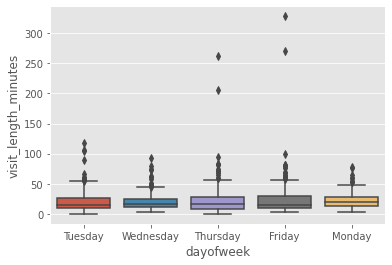

In [ ]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_final)

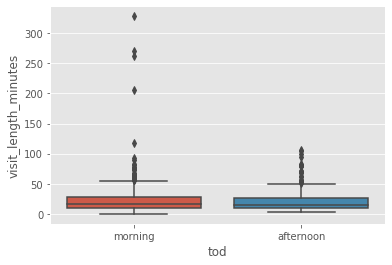

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

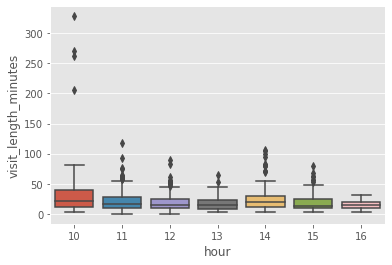

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

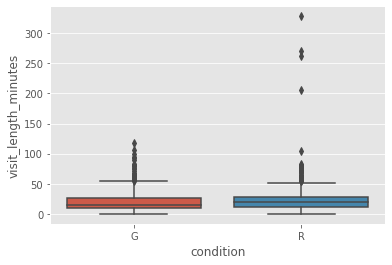

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

In [ ]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)]
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 233
newfrom                 233
newto                   233
visit_length            233
start_day               233
end_day                 233
sameday                 233
dayofweek               233
tod                     233
hour                    233
condition               233
visit_length_minutes    233
dtype: int64


In [ ]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 11:01:00,2021-11-30 11:10:00,0 days 00:09:00,30,30,equal,Tuesday,morning,11,G,9.0000
1,G1223,2021-11-30 11:14:00,2021-11-30 11:28:00,0 days 00:14:00,30,30,equal,Tuesday,morning,11,G,14.0000
2,G1224,2021-11-30 10:44:00,2021-11-30 11:06:00,0 days 00:22:00,30,30,equal,Tuesday,morning,10,G,22.0000
3,G1225,2021-11-30 10:44:00,2021-11-30 11:44:00,0 days 01:00:00,30,30,equal,Tuesday,morning,10,G,60.0000
4,G1226,2021-11-30 11:00:00,2021-11-30 11:13:00,0 days 00:13:00,30,30,equal,Tuesday,morning,11,G,13.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
1003,R1301,2022-01-27 10:32:00,2022-01-27 10:57:00,0 days 00:25:00,27,27,equal,Thursday,morning,10,R,25.0000
1005,R1303,2022-01-27 10:32:00,2022-01-27 11:47:00,0 days 01:15:00,27,27,equal,Thursday,morning,10,R,75.0000
1006,R1304,2022-01-28 10:31:00,2022-01-28 10:44:00,0 days 00:13:00,28,28,equal,Friday,morning,10,R,13.0000
1009,R2000,2021-12-20 10:37:00,2021-12-20 10:53:00,0 days 00:16:00,20,20,equal,Monday,morning,10,R,16.0000


In [ ]:
mean = df_outliers['visit_length_minutes'].mean()
print(mean)
print(df_nozero['visit_length_minutes'].mean())

20.902902902902902
20.94483450351053


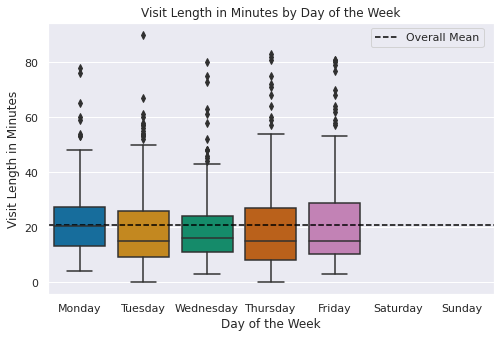

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated.png', bbox_inches='tight')

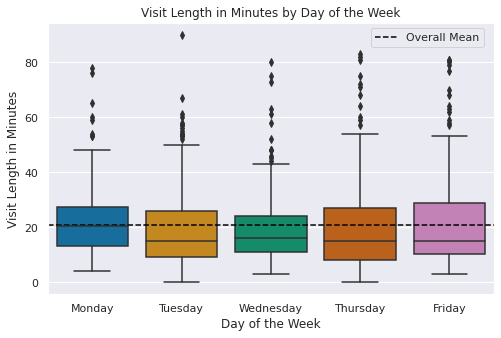

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated_noweekend.png', bbox_inches='tight')

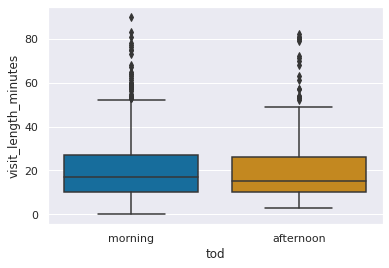

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

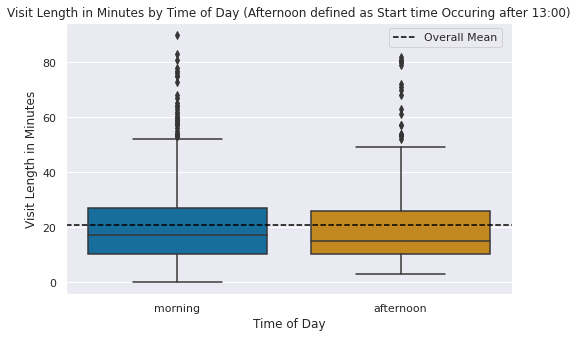

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Time of Day (Afternoon defined as Start time Occuring after 13:00)')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('timeofday_updated.png', bbox_inches='tight')

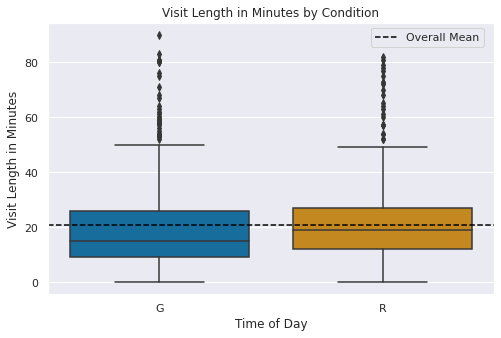

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Condition')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('condition_updated.png', bbox_inches='tight')

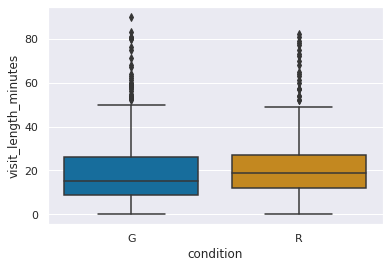

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

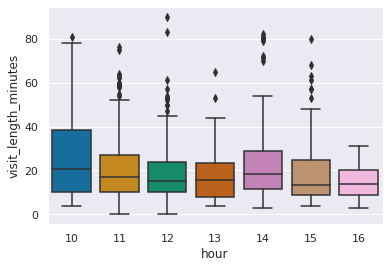

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

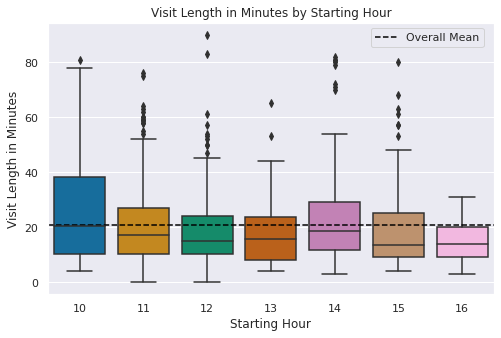

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Starting Hour')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('hour_updated.png', bbox_inches='tight')

In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df_outliers['visit_length_minutes'].describe()

count                                   999.0000
mean                                     20.9029
std                                      15.3610
min                                       0.0000
25%                                      10.0000
50%                                      16.0000
75%                                      27.0000
max                                      90.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].describe()

count                                 1,009.0000
mean                                     22.3598
std                                      22.7618
min                                       0.0000
25%                                      10.0000
50%                                      16.0000
75%                                      27.0000
max                                     328.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].median()

16.0

In [ ]:
df_outliers['visit_length'].describe()

count                          999
mean     0 days 00:20:54.174174174
std      0 days 00:15:21.658397725
min                0 days 00:00:00
25%                0 days 00:10:00
50%                0 days 00:16:00
75%                0 days 00:27:00
max                0 days 01:30:00
Name: visit_length, dtype: object

In [ ]:
df_final['visit_length'].describe()

count                         1009
mean     0 days 00:22:21.585728444
std      0 days 00:22:45.708092559
min                0 days 00:00:00
25%                0 days 00:10:00
50%                0 days 00:16:00
75%                0 days 00:27:00
max                0 days 05:28:00
Name: visit_length, dtype: object

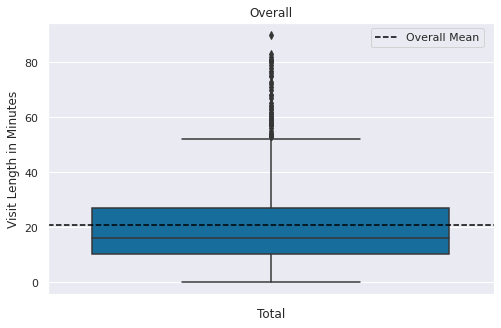

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)
svm.set_title('Overall')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('tested.png', bbox_inches='tight')

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
132
Eleven
246
Twelve
187
One
38
Two
188
Three
154
Four
54


In [ ]:
print('Monday Outlier')
mondayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Monday'].count()
print(mondayoutlier)

print('Tuesday Outlier')
tuesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Tuesday'].count()
print(tuesdayoutlier)

print('Wednesday Outlier')
wednesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Wednesday'].count()
print(wednesdayoutlier)

print('Thursday Outlier')
thursdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Thursday'].count()
print(thursdayoutlier)

print('Friday Outlier')
fridayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Friday'].count()
print(fridayoutlier)

print('Saturday Outlier')
saturdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Saturday'].count()
print(saturdayoutlier)

print('Sunday Outlier')
sundayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Sunday'].count()
print(sundayoutlier)

Monday Outlier
128
Tuesday Outlier
237
Wednesday Outlier
234
Thursday Outlier
214
Friday Outlier
186
Saturday Outlier
0
Sunday Outlier
0


In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length_minutes'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
dayoftheweekmean

dayofweek
Monday                                       23.0000
Tuesday                                      20.2911
Wednesday                                    19.6111
Thursday                                     20.6215
Friday                                       22.1882
Saturday                                         NaN
Sunday                                           NaN
Name: visit_length_minutes, dtype: float64

In [ ]:
print('G')
glaucomacount = df_outliers['condition'][df_outliers['condition']=='G'].count()
print(glaucomacount)

print('R')
rcount = df_outliers['condition'][df_outliers['condition']=='R'].count()
print(rcount)

G
630
R
369


In [ ]:
conditionmean = df_outliers.groupby('condition')['visit_length_minutes'].mean(numeric_only=False)
conditionmean

condition
G                                    20.2270
R                                    22.0569
Name: visit_length_minutes, dtype: float64

In [ ]:
print('morning')
morningcount = df_outliers['tod'][df_outliers['tod']=='morning'].count()
print(morningcount)

print('afternoon')
afternooncount = df_outliers['tod'][df_outliers['tod']=='afternoon'].count()
print(afternooncount)

morning
603
afternoon
396


In [ ]:
todmean = df_outliers.groupby('tod')['visit_length_minutes'].mean(numeric_only=False)
todmean

tod
afternoon                                    20.1465
morning                                      21.3997
Name: visit_length_minutes, dtype: float64

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
132
Eleven
246
Twelve
187
One
38
Two
188
Three
154
Four
54


In [ ]:
hourmean = df_outliers.groupby('hour')['visit_length_minutes'].mean(numeric_only=False)
hourmean

hour
10                                    25.5152
11                                    20.9715
12                                    19.5080
13                                    19.1842
14                                    22.9681
15                                    18.6104
16                                    14.7037
Name: visit_length_minutes, dtype: float64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count()

Patient                 233
newfrom                 233
newto                   233
visit_length            233
start_day               233
end_day                 233
sameday                 233
dayofweek               233
tod                     233
hour                    233
condition               233
visit_length_minutes    233
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] == 0).all(axis=1)].count()

Patient                 2
newfrom                 2
newto                   2
visit_length            2
start_day               2
end_day                 2
sameday                 2
dayofweek               2
tod                     2
hour                    2
condition               2
visit_length_minutes    2
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length']]).all(axis=1)].count()

Patient                 997
newfrom                 997
newto                   997
visit_length            997
start_day               997
end_day                 997
sameday                 997
dayofweek               997
tod                     997
hour                    997
condition               997
visit_length_minutes    997
dtype: int64

In [ ]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
76,G1304,2021-11-30 11:27:00,2021-11-30 11:27:00,0 days 00:00:00,30,30,equal,Tuesday,morning,11,G,0.0000
1001,R1256,2022-01-27 12:12:00,2022-01-27 12:12:00,0 days 00:00:00,27,27,equal,Thursday,morning,12,R,0.0000
91,G1322,2021-12-03 14:09:00,2021-12-03 14:12:00,0 days 00:03:00,3,3,equal,Friday,afternoon,14,G,3.0000
600,G1857,2022-01-27 12:19:00,2022-01-27 12:22:00,0 days 00:03:00,27,27,equal,Thursday,morning,12,G,3.0000
756,R0995,2021-12-21 11:56:00,2021-12-21 11:59:00,0 days 00:03:00,21,21,equal,Tuesday,morning,11,R,3.0000


In [ ]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
76,G1304,2021-11-30 11:27:00,2021-11-30 11:27:00,0 days 00:00:00,30,30,equal,Tuesday,morning,11,G,0.0000
1001,R1256,2022-01-27 12:12:00,2022-01-27 12:12:00,0 days 00:00:00,27,27,equal,Thursday,morning,12,R,0.0000
91,G1322,2021-12-03 14:09:00,2021-12-03 14:12:00,0 days 00:03:00,3,3,equal,Friday,afternoon,14,G,3.0000
600,G1857,2022-01-27 12:19:00,2022-01-27 12:22:00,0 days 00:03:00,27,27,equal,Thursday,morning,12,G,3.0000
756,R0995,2021-12-21 11:56:00,2021-12-21 11:59:00,0 days 00:03:00,21,21,equal,Tuesday,morning,11,R,3.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
468,G1719,2022-01-18 12:23:00,2022-01-18 13:53:00,0 days 01:30:00,18,18,equal,Tuesday,morning,12,G,90.0000
168,G1402,2021-12-09 12:24:00,2021-12-09 13:47:00,0 days 01:23:00,9,9,equal,Thursday,morning,12,G,83.0000
665,R0898,2021-12-02 14:57:00,2021-12-02 16:19:00,0 days 01:22:00,2,2,equal,Thursday,afternoon,14,R,82.0000
416,G1667,2022-01-14 10:39:00,2022-01-14 12:00:00,0 days 01:21:00,14,14,equal,Friday,morning,10,G,81.0000
424,G1675,2022-01-14 14:24:00,2022-01-14 15:45:00,0 days 01:21:00,14,14,equal,Friday,afternoon,14,G,81.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
468,G1719,2022-01-18 12:23:00,2022-01-18 13:53:00,0 days 01:30:00,18,18,equal,Tuesday,morning,12,G,90.0000
168,G1402,2021-12-09 12:24:00,2021-12-09 13:47:00,0 days 01:23:00,9,9,equal,Thursday,morning,12,G,83.0000
665,R0898,2021-12-02 14:57:00,2021-12-02 16:19:00,0 days 01:22:00,2,2,equal,Thursday,afternoon,14,R,82.0000
416,G1667,2022-01-14 10:39:00,2022-01-14 12:00:00,0 days 01:21:00,14,14,equal,Friday,morning,10,G,81.0000
424,G1675,2022-01-14 14:24:00,2022-01-14 15:45:00,0 days 01:21:00,14,14,equal,Friday,afternoon,14,G,81.0000


In [ ]:
df_final.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
1007,R1305,2022-01-28 10:31:00,2022-01-28 15:59:00,0 days 05:28:00,28,28,equal,Friday,morning,10,R,328.0000
1008,R1306,2022-01-28 10:31:00,2022-01-28 15:02:00,0 days 04:31:00,28,28,equal,Friday,morning,10,R,271.0000
1002,R1300,2022-01-27 10:32:00,2022-01-27 14:54:00,0 days 04:22:00,27,27,equal,Thursday,morning,10,R,262.0000
1004,R1302,2022-01-27 10:37:00,2022-01-27 14:02:00,0 days 03:25:00,27,27,equal,Thursday,morning,10,R,205.0000
205,G1440,2021-12-21 11:47:00,2021-12-21 13:44:00,0 days 01:57:00,21,21,equal,Tuesday,morning,11,G,117.0000
213,G1449,2021-12-21 14:21:00,2021-12-21 16:07:00,0 days 01:46:00,21,21,equal,Tuesday,afternoon,14,G,106.0000
982,R1236,2022-01-25 14:37:00,2022-01-25 16:21:00,0 days 01:44:00,25,25,equal,Tuesday,afternoon,14,R,104.0000
71,G1297,2021-12-03 14:11:00,2021-12-03 15:50:00,0 days 01:39:00,3,3,equal,Friday,afternoon,14,G,99.0000
348,G1588,2022-01-06 14:40:00,2022-01-06 16:14:00,0 days 01:34:00,6,6,equal,Thursday,afternoon,14,G,94.0000
306,G1546,2022-01-05 11:11:00,2022-01-05 12:44:00,0 days 01:33:00,5,5,equal,Wednesday,morning,11,G,93.0000


In [ ]:
df_outliers.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
468,G1719,2022-01-18 12:23:00,2022-01-18 13:53:00,0 days 01:30:00,18,18,equal,Tuesday,morning,12,G,90.0000
168,G1402,2021-12-09 12:24:00,2021-12-09 13:47:00,0 days 01:23:00,9,9,equal,Thursday,morning,12,G,83.0000
665,R0898,2021-12-02 14:57:00,2021-12-02 16:19:00,0 days 01:22:00,2,2,equal,Thursday,afternoon,14,R,82.0000
416,G1667,2022-01-14 10:39:00,2022-01-14 12:00:00,0 days 01:21:00,14,14,equal,Friday,morning,10,G,81.0000
424,G1675,2022-01-14 14:24:00,2022-01-14 15:45:00,0 days 01:21:00,14,14,equal,Friday,afternoon,14,G,81.0000
734,R0972,2021-12-09 14:06:00,2021-12-09 15:27:00,0 days 01:21:00,9,9,equal,Thursday,afternoon,14,R,81.0000
230,G1466,2021-12-22 14:19:00,2021-12-22 15:39:00,0 days 01:20:00,22,22,equal,Wednesday,afternoon,14,G,80.0000
537,G1792,2022-01-21 15:19:00,2022-01-21 16:39:00,0 days 01:20:00,21,21,equal,Friday,afternoon,15,G,80.0000
897,R1145,2022-01-14 14:04:00,2022-01-14 15:23:00,0 days 01:19:00,14,14,equal,Friday,afternoon,14,R,79.0000
965,R1215,2022-01-24 10:33:00,2022-01-24 11:51:00,0 days 01:18:00,24,24,equal,Monday,morning,10,R,78.0000


In [ ]:
df_outliers

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 11:01:00,2021-11-30 11:10:00,0 days 00:09:00,30,30,equal,Tuesday,morning,11,G,9.0000
1,G1223,2021-11-30 11:14:00,2021-11-30 11:28:00,0 days 00:14:00,30,30,equal,Tuesday,morning,11,G,14.0000
2,G1224,2021-11-30 10:44:00,2021-11-30 11:06:00,0 days 00:22:00,30,30,equal,Tuesday,morning,10,G,22.0000
3,G1225,2021-11-30 10:44:00,2021-11-30 11:44:00,0 days 01:00:00,30,30,equal,Tuesday,morning,10,G,60.0000
4,G1226,2021-11-30 11:00:00,2021-11-30 11:13:00,0 days 00:13:00,30,30,equal,Tuesday,morning,11,G,13.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
1003,R1301,2022-01-27 10:32:00,2022-01-27 10:57:00,0 days 00:25:00,27,27,equal,Thursday,morning,10,R,25.0000
1005,R1303,2022-01-27 10:32:00,2022-01-27 11:47:00,0 days 01:15:00,27,27,equal,Thursday,morning,10,R,75.0000
1006,R1304,2022-01-28 10:31:00,2022-01-28 10:44:00,0 days 00:13:00,28,28,equal,Friday,morning,10,R,13.0000
1009,R2000,2021-12-20 10:37:00,2021-12-20 10:53:00,0 days 00:16:00,20,20,equal,Monday,morning,10,R,16.0000


In [ ]:
df_outliers.loc[df_outliers['Patient'] == 'G1846']


,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
589,G1846,2022-01-26 16:56:00,2022-01-26 17:08:00,0 days 00:12:00,26,26,equal,Wednesday,afternoon,16,G,12.0000


In [ ]:
df_outliers['clinic_location'] = 'OCT'
df_outliers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes,clinic_location
0,G1221,2021-11-30 11:01:00,2021-11-30 11:10:00,0 days 00:09:00,30,30,equal,Tuesday,morning,11,G,9.0000,OCT
1,G1223,2021-11-30 11:14:00,2021-11-30 11:28:00,0 days 00:14:00,30,30,equal,Tuesday,morning,11,G,14.0000,OCT
2,G1224,2021-11-30 10:44:00,2021-11-30 11:06:00,0 days 00:22:00,30,30,equal,Tuesday,morning,10,G,22.0000,OCT
3,G1225,2021-11-30 10:44:00,2021-11-30 11:44:00,0 days 01:00:00,30,30,equal,Tuesday,morning,10,G,60.0000,OCT
4,G1226,2021-11-30 11:00:00,2021-11-30 11:13:00,0 days 00:13:00,30,30,equal,Tuesday,morning,11,G,13.0000,OCT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,R1301,2022-01-27 10:32:00,2022-01-27 10:57:00,0 days 00:25:00,27,27,equal,Thursday,morning,10,R,25.0000,OCT
1005,R1303,2022-01-27 10:32:00,2022-01-27 11:47:00,0 days 01:15:00,27,27,equal,Thursday,morning,10,R,75.0000,OCT
1006,R1304,2022-01-28 10:31:00,2022-01-28 10:44:00,0 days 00:13:00,28,28,equal,Friday,morning,10,R,13.0000,OCT
1009,R2000,2021-12-20 10:37:00,2021-12-20 10:53:00,0 days 00:16:00,20,20,equal,Monday,morning,10,R,16.0000,OCT


In [ ]:
OCTdf = df_outliers[['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes', 'clinic_location']].copy()

## CSV Creation

This creates a csv of the dataframe so that it can potentially be used in subsequent analysis.

In [ ]:
OCTdf.to_csv('OCTdf.csv', index=False)